In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping,CSVLogger

In [2]:
PATH="D:\df\\ai\cora"
hidden_units = [32,32]
LR=0.01
dropout_rate = 0.5
EPOCHS = 300
batch_size = 256

# Data Preparation

In [3]:
citations=pd.read_csv(PATH+"\\cora_cites.csv",names=['target','source'],header=1)
print(f"relation nodes={citations.shape}")
citations.head(4)

relation nodes=(5428, 2)


,target,source
0,35,1033
1,35,1688
2,35,1956
3,35,8865


In [4]:
temp=pd.read_csv(PATH+"\\cora.content",sep='\t')
_,features = temp.shape
del(temp)
columns=["paper_id"]+[f"fet_{idx}" for idx in range(features-2)]+["subject"]

papers=pd.read_csv(PATH+"\\cora.content",sep="\t",names=columns)
papers.head(10)

,paper_id,fet_0,fet_1,fet_2,fet_3,fet_4,fet_5,fet_6,fet_7,fet_8,...,fet_1424,fet_1425,fet_1426,fet_1427,fet_1428,fet_1429,fet_1430,fet_1431,fet_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
5,1126012,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Probabilistic_Methods
6,1107140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory
7,1102850,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
8,31349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks
9,1106418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Theory


In [5]:
#show outputs
print(papers["subject"].value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [6]:
LABELS=sorted(papers["subject"].unique())
class_idx = {name:idx for idx,name in enumerate(LABELS)}
papers_idx = {name:idx for idx,name in enumerate(sorted(papers["paper_id"].unique()))}

papers["subject"] = papers["subject"].apply(lambda name : class_idx[name])
papers["paper_id"] = papers["paper_id"].apply(lambda name : papers_idx[name])
citations["target"] = citations["target"].apply(lambda name : papers_idx[name])
citations["source"] = citations["source"].apply(lambda name : papers_idx[name])

[1766, 1275, 1895, 1840, 1750, 1502, 491, 492, 1616, 1491, 654, 274, 2684, 1662, 117, 87, 1626, 857, 1639, 0, 2067, 1113, 1721, 295, 2631, 131, 1790, 1134, 1331, 944, 362, 363, 1592, 585, 2233, 809, 1785, 384, 1341, 294, 1594, 107, 1899, 682, 2239, 1136, 939, 465, 2122, 505, 1770, 1771, 1514, 348, 1476, 148, 2645, 1038, 2342, 914, 1013, 952, 757, 1374, 353, 1492, 143, 427, 127, 1610, 488, 1683, 467, 2590, 49, 2421, 1442, 2521, 1807, 236, 279, 496, 1965, 301, 1546, 1190, 823, 1312, 690, 85, 1438, 618, 351, 2586, 1874, 244, 327, 113, 121, 737, 583, 1673, 1210, 2313, 68, 1638, 1614, 2243, 589, 723, 815, 2477, 1062, 2026, 224, 1251, 957, 1634, 644, 2254, 118, 556, 1030, 89, 2464, 1712, 1191, 471, 2425, 52, 2707, 152, 2443, 1707, 423, 642, 220, 2256, 1079, 536, 878, 1291, 200, 166, 869, 334, 115, 2338, 1569, 431, 894, 388, 340, 1163, 286, 503, 420, 2095, 1194, 2691, 110, 490, 763, 609, 535, 1439, 146, 2486, 1656, 931, 930, 2294, 355, 2495, 1775, 1997, 816, 198, 2323, 385, 2618, 1016, 42, 41

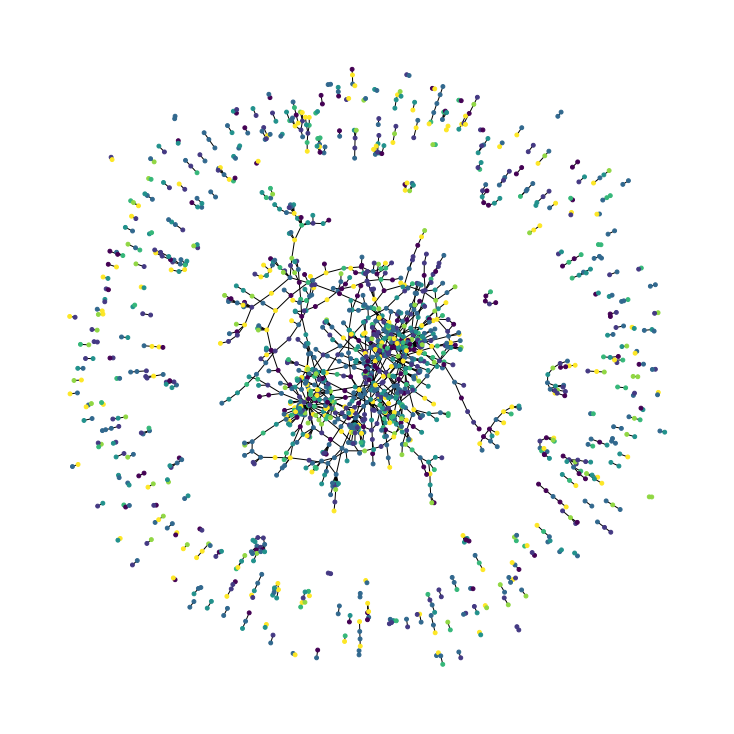

In [7]:
plt.figure(figsize=(10, 10))
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
print(cora_graph.nodes)
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [8]:
train,test = train_test_split(papers,test_size=0.3)
print(train["subject"].unique())
print(f"train data shape:{train.shape}")
print(f"test data shape:{test.shape}")


[2 3 1 6 0 4 5]
train data shape:(1895, 1435)
test data shape:(813, 1435)


In [9]:
features_names = list(set(papers.columns) - {"paper_id","subject"})


y_train = train["subject"].to_numpy()
y_test = test["subject"].to_numpy()

x_train = train['paper_id'].to_numpy()
x_test=test['paper_id'].to_numpy()

edges = citations[["source","target"]].to_numpy().T
node_features = tf.cast(papers.sort_values("paper_id")[features_names].to_numpy(),tf.float32)
edges_weights  = tf.ones(edges.shape[1]) #empty no weights in edges in cora dataset

print(f"\nedges shape :{edges.shape}")
print(f"node features shape :{node_features.shape}")
print(f"edges weights shape :{edges_weights.shape}")

graph_data = (node_features,edges,edges_weights)


edges shape :(2, 5428)
node features shape :(2708, 1433)
edges weights shape :(5428,)


# Build Model

## Build Necessary Layers

In [10]:
class FFN(layers.Layer):
    def __init__(self,units,dropout_rate):
        super(FFN,self).__init__()
        self.ffn_layers = []
        for unit in units:
            self.ffn_layers.append(layers.BatchNormalization())
            self.ffn_layers.append(layers.Dropout(dropout_rate))
            self.ffn_layers.append(layers.Dense(unit,activation=tf.nn.gelu))
        self.seq=keras.Sequential(self.ffn_layers)
    def call(self,inputs):
        return self.seq(inputs)
        



class GraphConv(layers.Layer):
    def __init__(self,units,dropout_rate=0.2,aggregation_type="mean",combination_type="concat",normalize = False):
        super(GraphConv,self).__init__()
        self.aggregation_type=aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = FFN(units,dropout_rate)
        self.update_fn = FFN(units,dropout_rate)
       
    def prepare(self,node_representations,weights=None):
        message = self.ffn_prepare(node_representations)
        if weights is not None :
            message *=tf.expand_dims(weights,axis= -1)
        return message
    def aggregate(self,nodes_id,neighbour_messages,node_representaions):
        num_nodes = node_representaions.shape[0]
        if self.aggregation_type == "sum" :
            aggregation = tf.math.unsorted_segment_sum(neighbour_messages,nodes_id,num_nodes)
        elif self.aggregation_type == "mean" :
            aggregation = tf.math.unsorted_segment_mean(neighbour_messages,nodes_id,num_nodes)
        elif self.aggregation_type == "max" :
            aggregation = tf.math.unsorted_segment_max(neighbour_messages,nodes_id,num_nodes)
        else :
            raise ValueError(f"invalid aggregation type :{self.aggregation_type}")
        return aggregation
    
    def update(self,node_representations,aggregate_messages):
            if self.combination_type == "concat" :
                comb = tf.concat([node_representations,aggregate_messages],axis= -1)
            elif self.combination_type == "add" :
                comb = node_representations+aggregate_messages
            else :
                raise ValueError(f"invalid combination type : {self.combination_type}")
            node_embeddings = self.update_fn(comb)
            
            if self.normalize:
                node_embeddings = tf.nn.l2_normalize(node_embeddings,axis=-1)
            return node_embeddings

    def call(self,inputs):
        node_representations,edges,edges_weights = inputs
        nodes_id,neighbours_id = edges[0],edges[1]
        neighbours_representations = tf.gather(node_representations,neighbours_id)

        messages = self.prepare(neighbours_representations,edges_weights)
        
        aggregated_messages = self.aggregate(nodes_id,messages,node_representations)

        output_embadings = self.update(node_representations,aggregated_messages)

        return output_embadings

## Model

In [11]:
class NodeClassifier(tf.keras.Model):
    def __init__(self,data,num_classes,hidden_units,aggregation_type="sum",combination_type="concat",dropout_rate=0.2,normalize=True):
        super(NodeClassifier,self).__init__()
        node_features,edges,edges_weights = data
        self.node_features=node_features
        self.edges=edges
        self.edges_weights=edges_weights

        if edges_weights is None :
            edges_weights = tf.ones(shape=edges.shape[1])
        self.edges_weights = edges_weights / tf.reduce_sum(self.edges_weights)

        self.preprocess = FFN(hidden_units,dropout_rate)

        self.gcn1= GraphConv(hidden_units,dropout_rate,aggregation_type,combination_type,normalize)
        self.gcn2= GraphConv(hidden_units,dropout_rate,aggregation_type,combination_type,normalize)
        self.postprocess = FFN(hidden_units,dropout_rate)
        self.output_layer = layers.Dense(num_classes)
    
    def call(self,input_nodes):
        x=self.preprocess(self.node_features)
        x1=self.gcn1([x,self.edges,self.edges_weights])
        x=x+x1
        x2=self.gcn2([x,self.edges,self.edges_weights])
        x=x2+x
        x=self.postprocess(x)
        node_embeddings=tf.gather(x,input_nodes)
        
        return self.output_layer(node_embeddings)



In [12]:


model = NodeClassifier(graph_data,len(LABELS),hidden_units)

print("model output :", model([32,10]))

model.summary()

model output : tf.Tensor(
[[-0.02449802  0.01990318  0.00816082 -0.06277694  0.00019746 -0.04324096
  -0.07665022]
 [-0.04139807 -0.00502636  0.18481767  0.01051459  0.10072445  0.08680219
  -0.03400394]], shape=(2, 7), dtype=float32)
Model: "node_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ffn (FFN)                   multiple                  52804     
                                                                 
 graph_conv (GraphConv)      multiple                  5888      
                                                                 
 graph_conv_1 (GraphConv)    multiple                  5888      
                                                                 
 ffn_5 (FFN)                 multiple                  2368      
                                                                 
 dense_12 (Dense)            multiple                  231       
              

# Training & Evaluate the model

In [13]:


model.compile(optimizer=keras.optimizers.Adam(LR),loss=keras.losses.SparseCategoricalCrossentropy(True),metrics=[keras.metrics.SparseCategoricalAccuracy("acc")])
early_stopping = EarlyStopping("val_acc",patience=50,restore_best_weights=True)
csv=CSVLogger("history.csv")

history= model.fit(x_train,y=y_train,epochs=EPOCHS,batch_size=batch_size,validation_split=0.1,callbacks=[early_stopping,csv])

Epoch 1/300
7/7 [==============================] - 4s 123ms/step - loss: 2.0225 - acc: 0.2141 - val_loss: 1.8840 - val_acc: 0.2684
Epoch 2/300
7/7 [==============================] - 0s 38ms/step - loss: 1.7416 - acc: 0.3390 - val_loss: 1.7996 - val_acc: 0.3053
Epoch 3/300
7/7 [==============================] - 0s 37ms/step - loss: 1.5266 - acc: 0.4211 - val_loss: 1.6500 - val_acc: 0.3842
Epoch 4/300
7/7 [==============================] - 0s 37ms/step - loss: 1.3112 - acc: 0.5138 - val_loss: 1.4267 - val_acc: 0.4421
Epoch 5/300
7/7 [==============================] - 0s 40ms/step - loss: 1.0521 - acc: 0.6199 - val_loss: 1.4689 - val_acc: 0.4842
Epoch 6/300
7/7 [==============================] - 0s 38ms/step - loss: 0.8257 - acc: 0.7208 - val_loss: 1.1549 - val_acc: 0.6053
Epoch 7/300
7/7 [==============================] - 0s 38ms/step - loss: 0.6556 - acc: 0.7871 - val_loss: 0.9795 - val_acc: 0.6947
Epoch 8/300
7/7 [==============================] - 0s 40ms/step - loss: 0.4878 - acc: 0.8

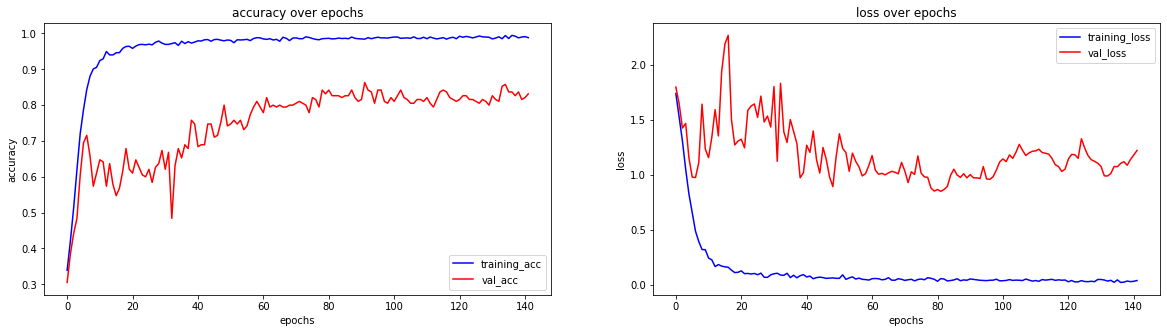

In [21]:
df=pd.read_csv("history.csv",names=["epochs","training_acc","training_loss","val_acc","val_loss"],header=1)
x=np.arange(df.shape[0])




infos=[["accuracy","training_acc","val_acc"],["loss","training_loss","val_loss"]]
fig,axes=plt.subplots(1,2,figsize=(20,5))
for i in range(2):
    axes[i].set_title(f"{infos[i][0]} over epochs")
    axes[i].set_xlabel("epochs")
    axes[i].set_ylabel(infos[i][0])
    axes[i].plot(x,df[infos[i][1]],label=infos[i][1],c="blue")
    axes[i].plot(x,df[infos[i][2]],label=infos[i][2],c="red")
    axes[i].legend()

In [27]:

test_loss, test_accuracy = model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Test accuracy: 81.80%
